In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [368]:
from data.utils import load_data
models = ['HadamardGP', 'BRR', 'SimpleGP', 'LSTM', 'XGBoost']
df_dict = {}
for model in models:
    print(model)
    df_dict[model] = load_data('Dissertation/reports/exogenous3', f'{model}.csv')
    df_dict[model].drop(columns=['Unnamed: 0'], inplace=True)
    


HadamardGP
==> Loading data
==> Loaded data in: 0 m : 0 sec

BRR
==> Loading data
==> Loaded data in: 0 m : 0 sec

SimpleGP
==> Loading data
==> Loaded data in: 0 m : 0 sec

LSTM
==> Loading data
==> Loaded data in: 0 m : 0 sec

XGBoost
==> Loading data
==> Loaded data in: 0 m : 0 sec



In [369]:
nlpd_dict = {}
models = ['HadamardGP','BRR', 'SimpleGP']
for model in models:
    nlpd_dict[model] = load_data('Dissertation/reports/exogenous2', f'{model}_nlpd.csv')
    nlpd_dict[model].drop(columns=['Unnamed: 0'], inplace=True)

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [371]:
def plot_forecast_mae(ax, results : dict, season : Optional[str] = None, pred_points=24):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
    

    plt.rcParams.update({'font.family': 'Arial'})
    
    for i, key in enumerate(results.keys()):
        mean = results[key]['mean']
        ax.plot(np.arange(0, pred_points), mean, color=colors[i], linestyle=linestyles[i], label=key)
    
    ax.set_title(f'{season.upper()}', fontsize=15)
  

In [392]:
def boxplot_models(ax, results : dict, season : Optional[str] = None):
    # boxplot of models MAE (mean and median)
    
    ax.boxplot([results[key]['mean'] for key in results.keys()], labels=results.keys(), showmeans=True)
    


In [385]:
def print_mae_table(dct, models, season : Optional[str] = None):
    """ 
    Print table with MAE
    """
    if season:
        print('-'*35)
        print(f'{" "*10} {season.upper()} {" "*10}')
    print('-'*35)
    print('| Model \t| MAE \t | STD Dev ')
    print('-'*35)
    for model in models:
        mae = dct[model].mean(axis=1).mean()
        std = dct[model].std(axis=1).mean()
        if model in ['BRR', 'LSTM']:
            print(f'| {model} \t\t | {mae:.3f} | {std:.3f} ')
        else:
            print(f'| {model} \t | {mae:.3f} | {std:.3f} ')
        

In [386]:
def print_nlpd_table(dct, season : Optional[str] = None):
    if season:
        print('-'*35)
        print(f'{" "*10} {season.upper()} {" "*10}')
    print('-'*35)
    print('| Model \t | NLPD  | STD Dev ')
    print('-'*35)
    for model in ['HadamardGP', 'SimpleGP', 'BRR']:
        mae = dct[model].mean(axis=1).mean()
        std = dct[model].std(axis=1).mean()
        if model in ['GP', 'BRR']:
            print(f'| {model} \t\t | {mae:.3f} | {std:.6f} ')
        else:
            print(f'| {model} \t | {mae:.3f} | {std:.6f} ')

In [387]:
print_nlpd_table(nlpd_dict)

-----------------------------------
| Model 	 | NLPD  | STD Dev 
-----------------------------------
| HadamardGP 	 | -0.010 | 0.030188 
| SimpleGP 	 | -0.009 | 0.032045 
| BRR 		 | -0.004 | 0.020519 


In [388]:
# we have 52 weeks and 6 systems --> 52*6 = 312 "weeks" in total starting from 1. Jan 2018

def winter_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx < 9*n_systems or idx > 48*n_systems]

def spring_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 9*n_systems and idx <= 22*n_systems]

def summer_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 22*n_systems and idx <= 35*n_systems]

def autumn_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 35*n_systems and idx <= 48*n_systems]

def filter_season(df_dict, models, season, split_str: str = 'mae', forecast_horizon : Optional[int] = None):
    
    filtered = {}
    experiment_idx = [int((col.split(split_str)[-1])) if len(col.split(split_str)) > 1 else -1 for col in df_dict[models[0]].columns]
    
    if season == 'winter':
        idx = winter_idx(experiment_idx)
    elif season == 'spring':
        idx = spring_idx(experiment_idx)
    
    elif season == 'summer':
        idx = summer_idx(experiment_idx)
    
    elif season == 'autumn':
        idx = autumn_idx(experiment_idx)
    else:
        raise ValueError('Season must be one of: winter, spring, summer, autumn')
    
    for model in models:
        try:
            if forecast_horizon:
                filtered[model] = df_dict[model].iloc[:forecast_horizon, idx]
            else:
                filtered[model] = df_dict[model].iloc[:, idx]
        except IndexError:
            idx = [i for i in idx if i < df_dict[model].shape[1]]
            if forecast_horizon:
                filtered[model] = df_dict[model].iloc[:forecast_horizon, idx]
            else:
                filtered[model] = df_dict[model].iloc[:, idx]
    
    for model in models:
        if 'Unnamed: 0' in filtered[model].columns:
            # ignore SettingWithCopyWarning
            with pd.option_context('mode.chained_assignment', None):
                filtered[model].drop('Unnamed: 0', axis=1, inplace=True)

    return filtered

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-----------------------------------
           WINTER           
-----------------------------------
| Model 	| MAE 	 | STD Dev 
-----------------------------------
| HadamardGP 	 | 0.038 | 0.055 
| BRR 		 | 0.046 | 0.058 
| SimpleGP 	 | 0.046 | 0.072 
| LSTM 		 | 0.063 | 0.078 
| XGBoost 	 | 0.063 | 0.075 
-----------------------------------
           WINTER           
-----------------------------------
| Model 	 | NLPD  | STD Dev 
-----------------------------------
| HadamardGP 	 | -0.031 | 0.038662 
| SimpleGP 	 | -0.028 | 0.041495 
| BRR 		 | -0.011 | 0.019541 
-----------------------------------
           SPRING           
-----------------------------------
| Model 	| MAE 	 | STD Dev 
-----------------------------------
| HadamardGP 	 | 0.102 | 0.101 
| BRR 		 | 0.111 | 0.099 
| SimpleGP 	 | 0.130 | 0.126 
| LSTM 		 | 0.130 | 0.124 
| XGBoost 	 | 0.105 | 0.104 
-----------------------------------
           SPRING           
-----------------------------------
| Model 	 | NLP

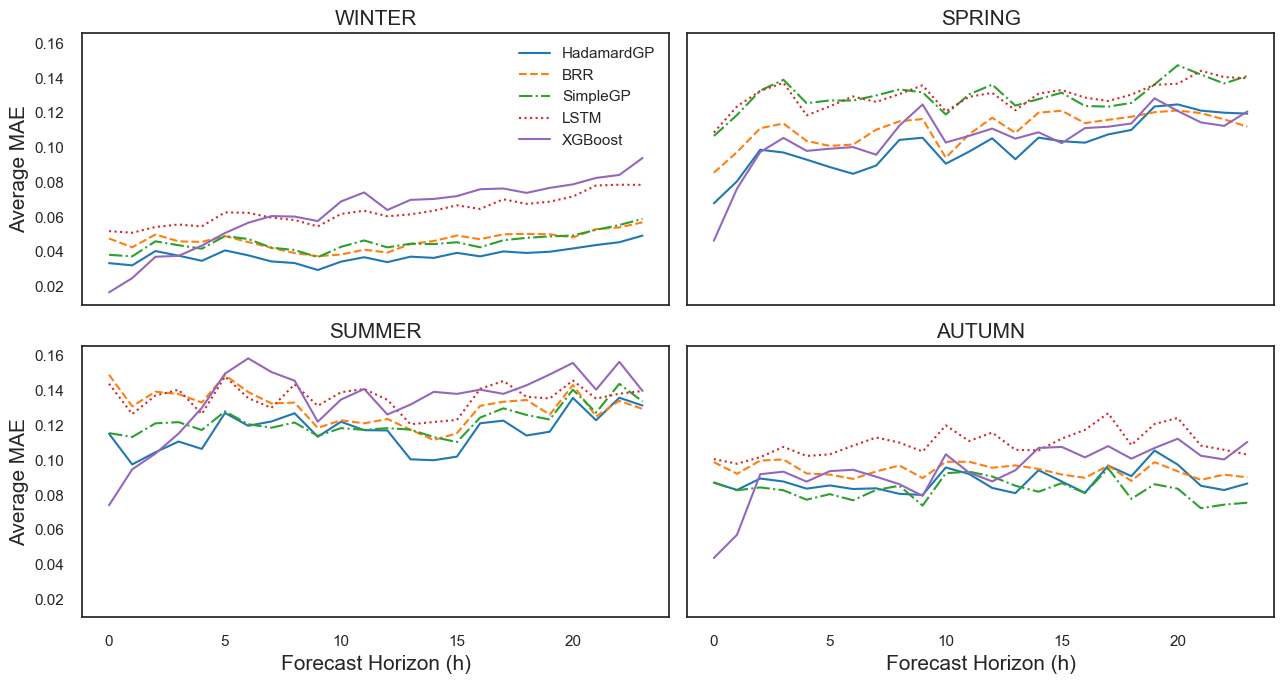

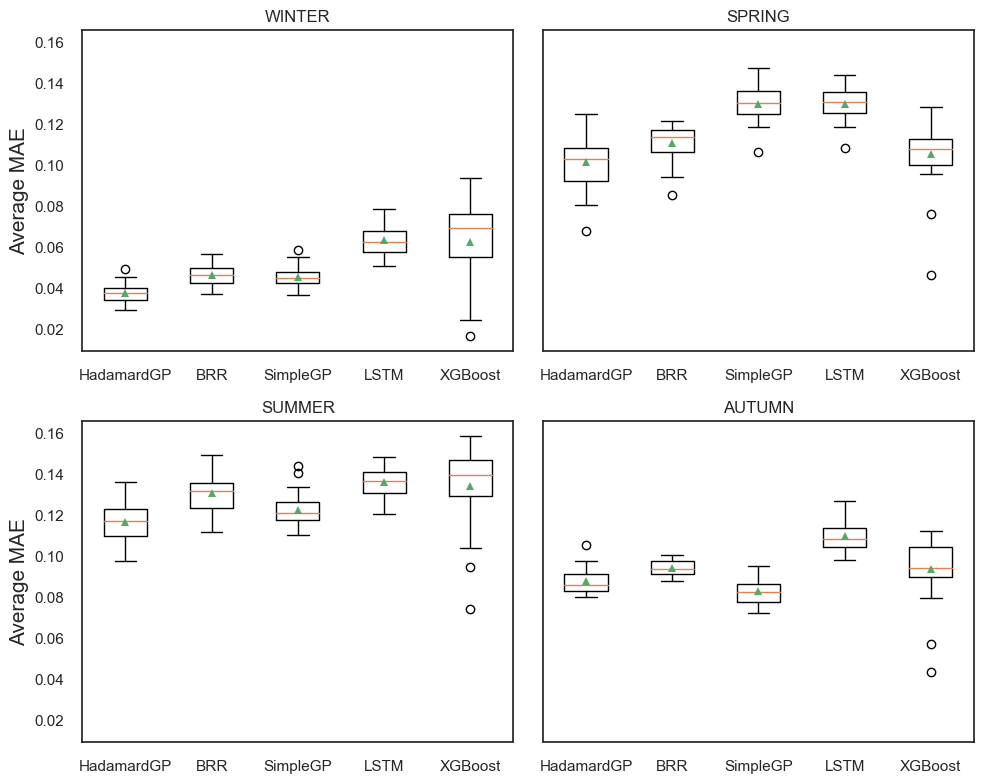

In [470]:
from metrics import get_mean_ci

fig, ax = plt.subplots(2, 2, figsize=(13, 7), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=True)

ax = ax.flatten()
ax2 = ax2.flatten()

models = ['HadamardGP', 'BRR', 'SimpleGP', 'LSTM', 'XGBoost']
models_nlpd = ['HadamardGP', 'BRR', 'SimpleGP']
for i, season in enumerate(['winter', 'spring', 'summer', 'autumn']):
    dict_season = filter_season(df_dict, models, season, forecast_horizon=24)
    nlpd_season = filter_season(nlpd_dict, models_nlpd, season, split_str='_', forecast_horizon=24)
    results = {}
    print_mae_table(dict_season, models, season)
    print_nlpd_table(nlpd_season, season)
    for model in dict_season.keys():
        mean, lower, upper = get_mean_ci(dict_season[model])
        #mean, lower, upper = mean[:24], lower[:24], upper[:24]
        results[model] = {'mean': mean, 'lower': lower, 'upper': upper}

    plot_forecast_mae(ax[i], results, pred_points=mean.shape[0], season=season)
    boxplot_models(ax2[i], results, season=season)
    ax2[i].set_title(f'{season.upper()}', fontsize=12)
    
    if i == 0:
        ax[i].legend(loc='best')
        ax2[i].legend(loc='best')
    
    # set ylabel only for left plots
    if i % 2 == 0:
        ax[i].set_ylabel('Average MAE', fontsize=15)
        ax2[i].set_ylabel('Average MAE', fontsize=15)
    
    # set xlabel only for bottom plots
    if i >= 2:
        #ax[i].set_xticks(np.arange(0, len(mean)), np.arange(1, len(mean) + 1))
        ax[i].set_xlabel('Forecast Horizon (h)', fontsize=15)

    
fig.tight_layout()
fig2.tight_layout()



In [464]:
from typing import Optional
import seaborn as sns

def boxplot_forecast_horizon(df_dict, pred_points=24, season : Optional[str] = None):
    
    fig, ax = plt.subplots(len(df_dict) // 2, 3, figsize=(15, 6), sharey=True, sharex=False)
    plt.rcParams.update({'font.family': 'Arial'})
    ax = ax.flatten()
    
    # change length to len(dict) for 2 hour forecast
    for i,  (key, df) in enumerate(df_dict.items()):
        df_transposed = df.T
        sns.boxplot(data=df_transposed, ax=ax[i], showfliers=False, medianprops={'color':'red'}, showmeans=True, color='white')
        ax[i].set_title(key, fontsize=15)
        if i % 3 == 0:
            ax[i].set_ylabel('MAE Errors', fontsize=15)

        # # set xticks on last plot
        #ax[i].set_xticklabels(np.arange(1, pred_points + 1), fontsize=10)
      
    if season is not None:
        title = season[0].upper() + season[1:]
        fig.suptitle(title, fontsize=20)

    # remove unused plots
    if len(df_dict) % 3 != 0:
        ax[-1].remove()
        
    
   

    plt.tight_layout()
    plt.show();

In [465]:
df_dict_test1 = {model: df_dict[model].iloc[:, :] for model in df_dict.keys()}
df_dict_test2 = {model: df_dict[model].iloc[:24, :] for model in df_dict.keys()}

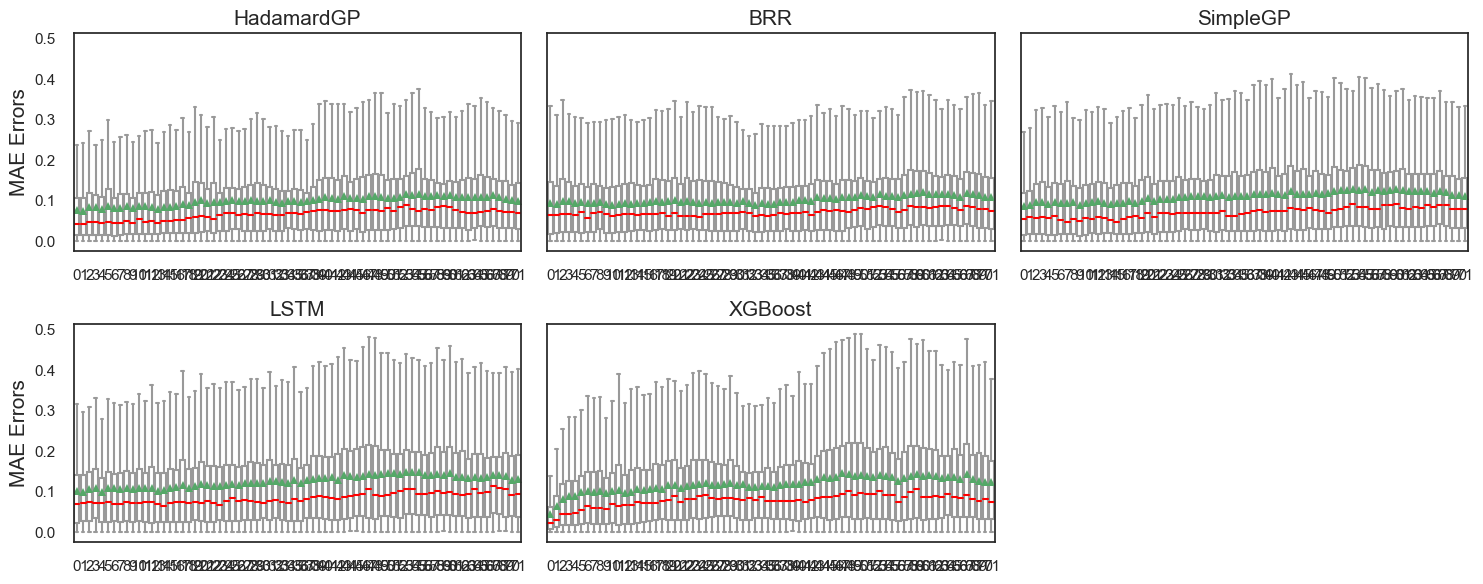

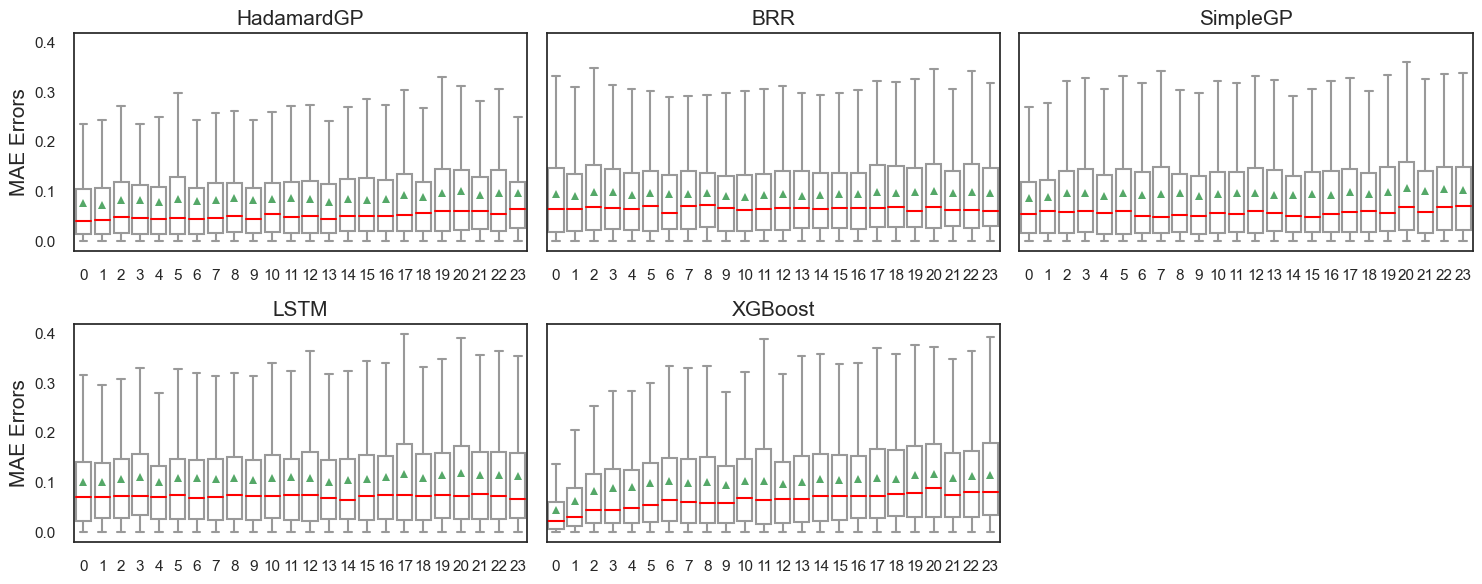

In [466]:
boxplot_forecast_horizon(df_dict_test1, pred_points = len(mean))
boxplot_forecast_horizon(df_dict_test2, pred_points = 24)